<a href="https://colab.research.google.com/github/vaibhavg23/travel_planner/blob/main/Travel_Planner_MultiAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Key Components
1. StateGraph: The core of our application, defining the flow of our Travel Planner.
2. PlannerState: A custom type representing the state of our planning process.
3. Node Functions: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. LLM Integration: Utilizing a language model to generate the final itinerary

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

In [ ]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

In [ ]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  budgets : str
  day : str
  itinerary: str

In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "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",
    model_name = "llama-3.3-70b-versatile"
)

In [ ]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a {day} trip itinerary for {city} based on the user's interests: {interests} based on the user's budgets: {budgets} and give price associated with it. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my {day} trip."),
])

In [ ]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }


def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip to : {state['city']} (comma-separted): ")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }
def input_budget(state: PlannerState) -> PlannerState:
  print(f"Please enter your budget for the trip to : {state['budgets']} ")
  user_message = input("Your Input: ")
  return {
      **state,
      "budgets": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }
def input_days(state: PlannerState) -> PlannerState:
  print(f"Please enter total number of days for the trip : {state['day']} ")
  user_message = input("Your Input: ")
  return {
      **state,
      "day": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['city']} based on interests : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_prompt.format_messages(city = state['city'], interests = ','.join(state['interests']),budgets = state['budgets'],day = state['day']))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

In [ ]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("input_budgets", input_budget)
workflow.add_node("input_days", input_days)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "input_budgets")
workflow.add_edge("input_budgets", "input_days")
workflow.add_edge("input_days", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()

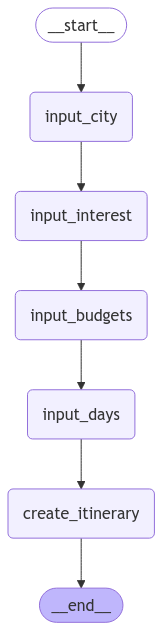

In [ ]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

In [ ]:
def travel_planner(user_request: str):
  print(f"Initial Request: {user_request}\n")
  state = {
      "messages": [HumanMessage(content=user_request)],
      "city": "",
      "interests": [],
      "budgets" : "",
      "day" : "",
      "itinerary": "",
  }
  for output in app.stream(state):d
    pass

IndentationError: unexpected indent (<ipython-input-32-2214acc7b043>, line 12)

In [ ]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: uttrakhand
Please enter your interest for the trip to : uttrakhand (comma-separted): 
Your Input: dehradhun
Please enter your budget for the trip to :  
Your Input: 5000
Please enter total number of days for the trip :  
Your Input: 2
Creating an itinerary for uttrakhand based on interests : dehradhun

Final Itinerary: 
Based on your interest in Dehradun, Uttarakhand, and a budget of 5000, I've created a 2-day itinerary for you. Here's a brief overview:

* **Day 1:**
  * Morning: Visit the Robber's Cave (entry fee: 25 per person)
  * Afternoon: Explore the Forest Research Institute (entry fee: 25 per person)
  * Evening: Enjoy a stroll at the Clock Tower and try some local street food (approx. 200 per person for food)
* **Day 2:**
  * Morning: Visit the Sahastradhara (entry fee: 20 per person) and take a cable car ride (approx. 100 per person)
  * Afternoon: Visit the Min

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation"]
  city: str
  interests: List[str]
  budgets : str
  day : str
  itinerary: str

# Define the LLM
llm = ChatGroq(
    temperature=0,
    groq_api_key="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",
    model_name="llama-3.3-70b-versatile"
)

# Define the itinerary prompt
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a {day} trip itinerary for {city} based on the user's interests: {interests} based on the user's budgets: {budgets} and give price associated with it. Provide a brief, bulleted itinerary."),
    ("human", "Create an itinerary for my {day} trip."),
])

def input_city(city: str, state: PlannerState) -> PlannerState:
  # The 'city' argument now comes from Gradio
  return {
      **state,
      "city": city,
      "messages": state['messages'] + [HumanMessage(content=city)]
  }

def input_interests(interests: str, state: PlannerState) -> PlannerState:
  # The 'interests' argument now comes from Gradio
  return {
      **state,
      "interests": [interest.strip() for interest in interests.split(",")],
      "messages": state['messages'] + [HumanMessage(content=interests)]
  }

def input_budget(budgets: str, state: PlannerState) -> PlannerState:
  # The 'budgets' argument now comes from Gradio
  return {
      **state,
      "budgets": budgets,
      "messages": state['messages'] + [HumanMessage(content=budgets)]
  }

def input_days(day: str, state: PlannerState) -> PlannerState:
  # The 'day' argument now comes from Gradio
  return {
      **state,
      "day": day,
      "messages": state['messages'] + [HumanMessage(content=day)]
  }
def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating an itinerary for {state['day']} {state['city']} based on interests : {', '.join(state['interests'])} {state['budgets']}")
  response = llm.invoke(itinerary_prompt.format_messages(day = state['day'],city = state['city'], interests = ','.join(state['interests']),budgets = state['budgets']))
  print("\nFinal Itinerary: ")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary" : response.content,
  }

# Define the Gradio application
def travel_planner(city: str, interests: str, budgets: str, day: str):
    # Initialize state
    state = {
        "messages": [],  # Start with an empty message list
        "city": "",
        "interests": [],
        "budgets": "",
        "day": "",
        "itinerary": "",
    }

    # Process inputs using the adapted functions
    state = input_city(city, state)
    state = input_interests(interests, state)
    state = input_budget(budgets, state)
    state = input_days(day, state)

    # Generate the itinerary
    state = create_itinerary(state)  # Call your existing create_itinerary function

    return state["itinerary"]  # Return the generated itinerary

# Build the Gradio interface
interface = gr.Interface(
    fn=travel_planner,
    inputs=[
        gr.Textbox(label="Enter the city for your day trip"),
        gr.Textbox(label="Enter your interests (comma-separated)"),
        gr.Textbox(label="Enter your budget"),
        gr.Textbox(label="Enter the number of days for the trip")
    ],
    outputs=gr.Textbox(label="Generated Itinerary"),
    title="Travel Itinerary Planner",
    description="Enter a city and your interests to generate a personalized day trip itinerary."
)

interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e11e4e58524dbadfff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
